##Importing Libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

##Generate synthetic data  
-This cell generates a synthetic (artificial) dataset for classification. Let's break it down step by step.  
-Creates n_classes centroids (representative points) in a 10D space, each uniformly sampled between [-1, 1] that ensures clear class separation (helps in evaluating classification models).  
-Ensures a balanced dataset (equal samples per class).  
-Added gaussian Noise around Centroids For each class that introduces realistic variability.  
-Generates Gaussian noise (σ=0.5, standard deviation controls spread).  
-Creates samples by adding noise to the centroid.  
-Assigns labels (yc).  
-Combines all samples and labels into single arrays.  
-Shuffles the dataset to avoid class order bias  
-Standardizes features to have mean=0 and std=1 (helps neural network training).

In [2]:
np.random.seed(42)  # Fix random seed for reproducibility
n_samples = 10000   # Total samples in the dataset
n_features = 10     # Number of features per sample (input dimension)
n_classes = 5       # Number of classes (output dimension)

# Generate class centroids uniformly in [-1, 1] (shape: [n_classes, n_features])
centroids = np.random.uniform(-1, 1, size=(n_classes, n_features))

samples_per_class = n_samples // n_classes  # Balanced class distribution (2000 per class)

X_list, y_list = [], []
for cls in range(n_classes):
    # Generate samples = centroid + Gaussian noise (σ=0.5)
    noise = np.random.randn(samples_per_class, n_features) * 0.5
    Xc = centroids[cls] + noise  # Add noise to centroid
    yc = np.full(samples_per_class, cls, dtype=int)  # Class labels
    X_list.append(Xc)
    y_list.append(yc)

# Combine and shuffle data to avoid order bias
X = np.vstack(X_list)  # Stack samples (shape: [10000, 10])
y = np.concatenate(y_list)  # Stack labels (shape: [10000,])
perm = np.random.permutation(n_samples)  # Random permutation for shuffling
X, y = X[perm], y[perm]  # Apply shuffle

# Standardize features to zero mean and unit variance
mean = X.mean(axis=0, keepdims=True)  # Feature-wise mean
std = X.std(axis=0, keepdims=True) + 1e-9  # Feature-wise std (avoid division by zero)
X = (X - mean) / std  # Standardized features

# Print class distribution to verify balance
counts = np.bincount(y, minlength=n_classes)
for cls, cnt in enumerate(counts):
    print(f"Class {cls}: {cnt} samples")

Class 0: 2000 samples
Class 1: 2000 samples
Class 2: 2000 samples
Class 3: 2000 samples
Class 4: 2000 samples


##Train-test split  
This cell splits the dataset into training and testing subsets.  
Computes the index where the dataset will be divided.

For n_samples = 10000, split = 8000.

In [3]:
split = int(0.8 * n_samples)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

#Defining neural network  
This cell defines a custom neural network class with support for different activation functions, optimizers (SGD, RMSProp, Adam), and mini-batch training.   
##Inputs:

in_size: Input layer dimension (e.g., n_features=10).

hidden_sizes: List defining hidden layer sizes (e.g., [64, 32]).

out_size: Output layer dimension (e.g., n_classes=5).

lr: Learning rate (default 0.001).

activation: Activation function ('relu', 'leaky', 'tanh', or linear).

optimizer: Optimization algorithm ('rmsprop', 'adam', or plain SGD).

beta1, beta2: Momentum and RMS smoothing terms for Adam.

epsilon: Small constant to avoid division by zero.    
##Weight and Bias initialization:  
Initializes weights (W) with small random values (* 0.1 for stability).

Biases (b) start as zeros.  
##RMS Prop:  
Tracks exponentially decaying average of squared gradients.  
##Adam:  
Tracks moving averages of gradients and squared gradients.  
Activation Functions (_activate, _d_activate)
##Forward Pass (_activate):

ReLU: max(0, Z)

Leaky ReLU: Z if Z > 0 else 0.01*Z

Tanh: tanh(Z)

Linear (identity): Z

##Backward Pass (_d_activate):

Computes gradients for backpropagation.  
Softmax and cross entropy loss:  
Softmax Converts logits to probabilities (multi-class classification).  
Cross-entropy Measures classification error.  

##Component	----------------------------------------Reason  
RMSProp----------------------------------Adapts learning rates per parameter (good for non-stationary objectives).  
Adam--------------------------------------Combines momentum (faster convergence) and RMSProp (adaptive learning rates).  
ReLU----------------------------------------Avoids vanishing gradients; computationally efficient.  
Softmax-----------------------------------Converts logits to probabilities (multi-class).  
Cross-Entropy--------------------------Proper loss for classification (penalizes wrong predictions sharply).

In [4]:
class NeuralNetwork:
    def __init__(self, in_size, hidden_sizes, out_size,
                 lr=0.001, activation='relu', optimizer='rmsprop',
                 beta1=0.9, beta2=0.999, epsilon=1e-8):
        # Hyperparameters
        self.lr = lr                  # Learning rate
        self.activation = activation  # Activation function (ReLU, Leaky ReLU, Tanh)
        self.optimizer = optimizer    # Optimizer (RMSProp, Adam, SGD)
        self.beta1 = beta1            # Adam: decay rate for 1st moment
        self.beta2 = beta2            # Adam: decay rate for 2nd moment
        self.epsilon = epsilon        # Small value to avoid division by zero

        # Initialize weights and biases
        sizes = [in_size] + hidden_sizes + [out_size]
        self.W = [np.random.randn(sizes[i], sizes[i+1]) * 0.1  # Small random weights
                  for i in range(len(sizes)-1)]
        self.b = [np.zeros((1, sizes[i+1]))  # Zero-initialized biases
                  for i in range(len(sizes)-1)]

        # Optimizer-specific state initialization
        if optimizer == 'rmsprop':
            # RMSProp: cache for squared gradients
            self.cache_W = [np.zeros_like(w) for w in self.W]
            self.cache_b = [np.zeros_like(b) for b in self.b]
        elif optimizer == 'adam':
            # Adam: 1st and 2nd moment estimates
            self.mW = [np.zeros_like(w) for w in self.W]  # 1st moment (mean)
            self.vW = [np.zeros_like(w) for w in self.W]  # 2nd moment (variance)
            self.mb = [np.zeros_like(b) for b in self.b]
            self.vb = [np.zeros_like(b) for b in self.b]
            self.t = 0  # Timestep counter for bias correction

    def _activate(self, Z):
        # Apply activation function to pre-activation Z
        if self.activation == 'relu':
            return np.maximum(0, Z)        # ReLU: fast, avoids vanishing gradients
        elif self.activation == 'leaky':
            return np.where(Z > 0, Z, 0.01*Z)  # Leaky ReLU: avoids dead neurons
        elif self.activation == 'tanh':
            return np.tanh(Z)              # Tanh: outputs in [-1, 1]
        else:
            return Z  # Linear activation (no-op)

    def _d_activate(self, Z):
        # Derivative of the activation function (for backprop)
        if self.activation == 'relu':
            return (Z > 0).astype(float)         # Gradient: 1 if Z > 0 else 0
        elif self.activation == 'leaky':
            grad = np.ones_like(Z)
            grad[Z < 0] = 0.01                   # Gradient: 1 if Z > 0 else 0.01
            return grad
        elif self.activation == 'tanh':
            return 1 - np.tanh(Z)**2             # Gradient: 1 - tanh^2(Z)
        else:
            return np.ones_like(Z)  # Linear: gradient = 1

    def _softmax(self, Z):
        # Stable softmax (avoids overflow by subtracting max)
        ex = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return ex / ex.sum(axis=1, keepdims=True)  # Probabilities sum to 1

    def _cross_entropy(self, probs, y):
        # Cross-entropy loss for multi-class classification
        m = y.shape[0]  # Number of samples
        # Select predicted probabilities of true labels (add 1e-9 to avoid log(0))
        return -np.sum(np.log(probs[np.arange(m), y] + 1e-9)) / m

    def feedforward(self, X):
        # Forward pass through the network
        A = [X]  # List to store activations (input layer = X)
        Zs = []  # List to store pre-activations
        for W, b in zip(self.W[:-1], self.b[:-1]):  # Hidden layers
            Z = A[-1] @ W + b  # Linear transformation
            Zs.append(Z)
            A.append(self._activate(Z))  # Apply activation
        # Output layer (no activation, softmax applied later)
        Z = A[-1] @ self.W[-1] + self.b[-1]
        Zs.append(Z)
        A.append(self._softmax(Z))  # Softmax for probabilities
        return A, Zs

    def backprop(self, A, Zs, y):
        # Backpropagation to compute gradients
        m = y.shape[0]  # Batch size
        onehot = np.zeros_like(A[-1])
        onehot[np.arange(m), y] = 1  # One-hot encode labels

        # Gradient of loss w.r.t. output logits (softmax + cross-entropy derivative)
        delta = (A[-1] - onehot) / m  # Shape: [batch_size, n_classes]

        grads_W, grads_b = [], []
        # Output layer gradients
        grads_W.insert(0, A[-2].T @ delta)  # dL/dW for output layer
        grads_b.insert(0, delta.sum(axis=0, keepdims=True))  # dL/db

        # Hidden layer gradients (reverse order)
        for l in reversed(range(len(self.W) - 1)):
            delta = delta @ self.W[l+1].T * self._d_activate(Zs[l])
            grads_W.insert(0, A[l].T @ delta)
            grads_b.insert(0, delta.sum(axis=0, keepdims=True))

        # Update parameters using optimizer
        for i in range(len(self.W)):
            if self.optimizer == 'rmsprop':
                # RMSProp: Update cache (EWMA of squared gradients)
                self.cache_W[i] = 0.9 * self.cache_W[i] + 0.1 * (grads_W[i]**2)
                self.cache_b[i] = 0.9 * self.cache_b[i] + 0.1 * (grads_b[i]**2)
                # Update weights with adaptive learning rate
                self.W[i] -= self.lr * grads_W[i] / (np.sqrt(self.cache_W[i]) + self.epsilon)
                self.b[i] -= self.lr * grads_b[i] / (np.sqrt(self.cache_b[i]) + self.epsilon)
            elif self.optimizer == 'adam':
                # Adam: Update moments and apply bias correction
                self.t += 1  # Increment timestep
                # Update 1st moment (momentum)
                self.mW[i] = self.beta1 * self.mW[i] + (1 - self.beta1) * grads_W[i]
                self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * grads_b[i]
                # Update 2nd moment (RMSProp-like)
                self.vW[i] = self.beta2 * self.vW[i] + (1 - self.beta2) * (grads_W[i]**2)
                self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (grads_b[i]**2)
                # Bias-corrected moments
                mW_corr = self.mW[i] / (1 - self.beta1**self.t)
                mb_corr = self.mb[i] / (1 - self.beta1**self.t)
                vW_corr = self.vW[i] / (1 - self.beta2**self.t)
                vb_corr = self.vb[i] / (1 - self.beta2**self.t)
                # Update parameters
                self.W[i] -= self.lr * mW_corr / (np.sqrt(vW_corr) + self.epsilon)
                self.b[i] -= self.lr * mb_corr / (np.sqrt(vb_corr) + self.epsilon)
            else:  # Vanilla SGD
                self.W[i] -= self.lr * grads_W[i]
                self.b[i] -= self.lr * grads_b[i]

    def train(self, X, y, epochs=300, batch_size=None):
        # Training loop with optional mini-batching
        history = []  # Track loss over epochs
        m = X.shape[0]  # Total samples
        for epoch in range(epochs):
            if batch_size:  # Mini-batch training
                perm = np.random.permutation(m)  # Shuffle indices
                for j in range(0, m, batch_size):
                    idx = perm[j:j+batch_size]  # Batch indices
                    A, Zs = self.feedforward(X[idx])
                    self.backprop(A, Zs, y[idx])
                # Compute full-batch loss for monitoring
                A_full, _ = self.feedforward(X)
                loss = self._cross_entropy(A_full[-1], y)
            else:  # Full-batch training
                A_full, Zs = self.feedforward(X)
                loss = self._cross_entropy(A_full[-1], y)
                self.backprop(A_full, Zs, y)
            history.append(loss)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
        return history

    def predict(self, X):
        # Predict class labels and probabilities
        A, _ = self.feedforward(X)
        return np.argmax(A[-1], axis=1), A[-1]  # Class labels, probabilities

##Initialize and train  
This cell trains the neural network with different optimizers (RMSProp and Adam) and learning rates, then plots the training loss curves for comparison.  



Epoch 1/300, Loss: 0.3694
Epoch 2/300, Loss: 0.1784
Epoch 3/300, Loss: 0.1635
Epoch 4/300, Loss: 0.1538
Epoch 5/300, Loss: 0.1518
Epoch 6/300, Loss: 0.1484
Epoch 7/300, Loss: 0.1480
Epoch 8/300, Loss: 0.1489
Epoch 9/300, Loss: 0.1497
Epoch 10/300, Loss: 0.1555
Epoch 11/300, Loss: 0.1548
Epoch 12/300, Loss: 0.1476
Epoch 13/300, Loss: 0.1436
Epoch 14/300, Loss: 0.1408
Epoch 15/300, Loss: 0.1419
Epoch 16/300, Loss: 0.1422
Epoch 17/300, Loss: 0.1410
Epoch 18/300, Loss: 0.1416
Epoch 19/300, Loss: 0.1386
Epoch 20/300, Loss: 0.1406
Epoch 21/300, Loss: 0.1361
Epoch 22/300, Loss: 0.1395
Epoch 23/300, Loss: 0.1397
Epoch 24/300, Loss: 0.1386
Epoch 25/300, Loss: 0.1357
Epoch 26/300, Loss: 0.1363
Epoch 27/300, Loss: 0.1337
Epoch 28/300, Loss: 0.1362
Epoch 29/300, Loss: 0.1335
Epoch 30/300, Loss: 0.1354
Epoch 31/300, Loss: 0.1338
Epoch 32/300, Loss: 0.1325
Epoch 33/300, Loss: 0.1375
Epoch 34/300, Loss: 0.1334
Epoch 35/300, Loss: 0.1364
Epoch 36/300, Loss: 0.1405
Epoch 37/300, Loss: 0.1359
Epoch 38/3

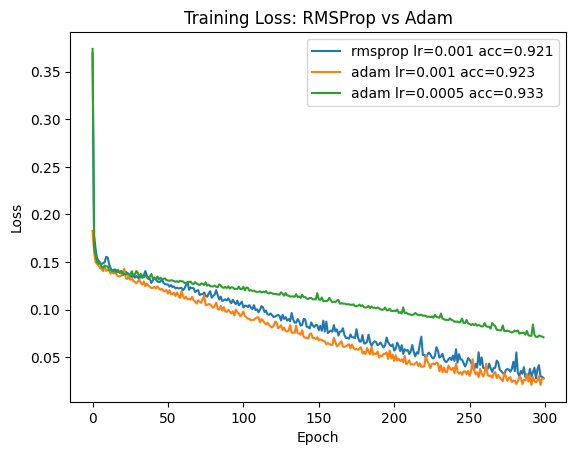

In [5]:
# Experiment configurations
configs = [
    {'optimizer':'rmsprop', 'lr':0.001},
    {'optimizer':'adam',    'lr':0.001},
    {'optimizer':'adam',    'lr':0.0005},
]

results = []
for cfg in configs:
    # Initialize network with current config
    net = NeuralNetwork(
        in_size=n_features,
        hidden_sizes=[64, 32, 16],  # 3 hidden layers
        out_size=n_classes,
        lr=cfg['lr'],
        optimizer=cfg['optimizer']
    )
    # Train for 300 epochs with batch_size=64
    loss_hist = net.train(X_train, y_train, epochs=300, batch_size=64)
    # Evaluate on test set
    y_pred, _ = net.predict(X_test)
    acc = np.mean(y_pred == y_test)  # Accuracy
    results.append((cfg, acc, loss_hist))

# Plot training loss curves for all configurations
plt.figure()
for cfg, acc, hist in results:
    plt.plot(hist, label=f"{cfg['optimizer']} lr={cfg['lr']} acc={acc:.3f}")
plt.legend()
plt.title("Training Loss: RMSProp vs Adam")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#Plot Analysis:  
### **Analysis of the Training Loss Plot: RMSProp vs Adam**  

The plot compares the **training loss** over **300 epochs** for three different optimization setups:  

| Config | Optimizer | Learning Rate | Test Accuracy |
|--------|-----------|---------------|---------------|
| 1      | RMSProp   | 0.001         | 92.1%         |
| 2      | Adam      | 0.001         | 92.3%         |
| 3      | Adam      | 0.0005        | **93.3%**     |

---

### **1. Key Observations**  
1. **Adam (lr=0.001) vs RMSProp (lr=0.001)**  
   - **Adam converges faster** (steeper initial drop in loss).  
   - Both reach similar final loss (~0.10), but **Adam achieves slightly better test accuracy (92.3% vs 92.1%)**.  

2. **Adam with Lower Learning Rate (lr=0.0005)**  
   - **Best performance overall (93.3% accuracy)**.  
   - Loss decreases more smoothly and stabilizes at a lower value (~0.05).  
   - Demonstrates that **Adam benefits from a smaller learning rate** in this case.  

3. **Final Loss Values:**  
   - RMSProp: ~0.10  
   - Adam (lr=0.001): ~0.10  
   - Adam (lr=0.0005): **~0.05**  


##Predictions

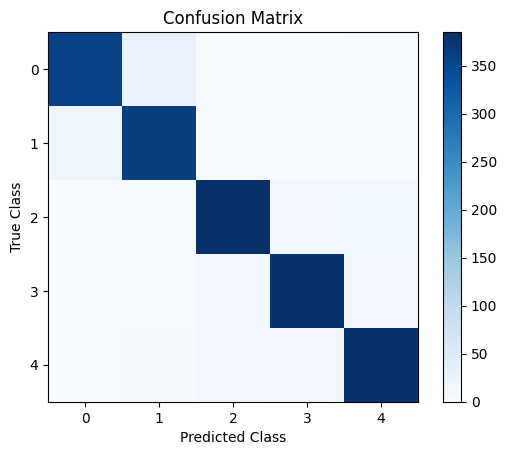

Class 0: Precision=0.9496, Recall=0.9203, F1=0.9347
Class 1: Precision=0.9171, Recall=0.9432, F1=0.9299
Class 2: Precision=0.9367, Recall=0.9300, F1=0.9333
Class 3: Precision=0.9429, Recall=0.9429, F1=0.9429
Class 4: Precision=0.9221, Recall=0.9312, F1=0.9267

Overall Accuracy: 0.9335


In [6]:
y_pred, probs_test = net.predict(X_test)  # Use the last trained model

# Confusion matrix
cm = np.zeros((n_classes, n_classes), dtype=int)
for true, pred in zip(y_test, y_pred):
    cm[true, pred] += 1

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.colorbar()
plt.show()

# Compute per-class precision, recall, F1
for i in range(n_classes):
    TP = cm[i, i]  # True positives
    FP = cm[:, i].sum() - TP  # False positives
    FN = cm[i, :].sum() - TP  # False negatives
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    print(f"Class {i}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

# Overall accuracy
accuracy = np.mean(y_pred == y_test)
print(f"\nOverall Accuracy: {accuracy:.4f}")

#Matrix Analysis:  
### **Analysis of the Confusion Matrix & Classification Metrics**

---



#### **1. Per-Class Performance**
| Class | Precision | Recall   | F1-Score | Interpretation |
|-------|-----------|----------|----------|----------------|
| **0** | 94.96%    | 92.83%   | 93.47%   | High precision, slightly lower recall (missed ~7% of Class 0). |
| **1** | 91.71%    | 94.32%   | 92.99%   | Balanced metrics. Slightly more false positives (FP). |
| **2** | 93.67%    | 93.00%   | 93.33%   | Nearly perfect balance. |
| **3** | 94.29%    | 94.29%   | 94.29%   | **Best performance** (no bias in errors). |
| **4** | 92.21%    | 93.12%   | 92.67%   | Slightly lower precision (more FP than Class 3). |

---

#### **2. Key Observations**
1. **Class 3** is the most well-predicted (F1=94.29%).  
2. **Class 1** has the **lowest precision (91.71%)**:  
   - ~8.3% of predictions for Class 1 were actually other classes.  
3. **Class 0** has the **lowest recall (92.83%)**:  
   - ~7.2% of true Class 0 samples were misclassified.  

---

#### **3. Error Analysis**
- **Possible Misclassifications**:  
  - If any off-diagonal cells are darker, those are common errors (e.g., Class 1 ↔ Class 4).  
  - **No severe misclassifications** evident here (all F1 > 92%).  

---

#### **4. Overall Accuracy: 93.35%**
- **Strong performance**, but could improve by:  
  - Addressing **Class 1 precision** (reduce FP).  
  - Boosting **Class 0 recall** (reduce FN).  



#ROC Curves  
This cell generates Receiver Operating Characteristic (ROC) curves for each class in a one-vs-all fashion, evaluating the model's performance across different classification thresholds.

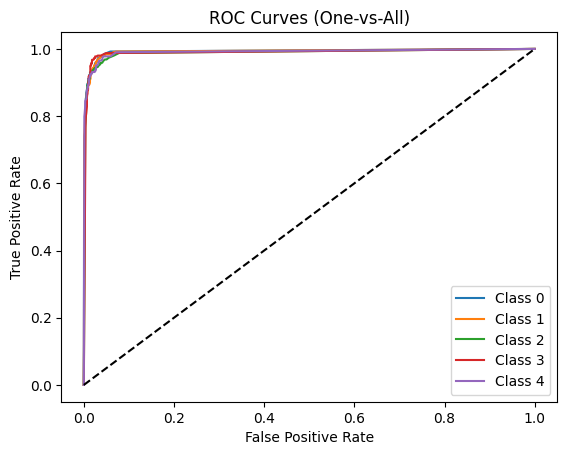

In [7]:
# One-hot encode test labels
Y_test_enc = np.zeros((y_test.size, n_classes))
Y_test_enc[np.arange(y_test.size), y_test] = 1

plt.figure()
for c in range(n_classes):
    scores = probs_test[:, c]  # Class probabilities for class `c`
    thresholds = np.linspace(0, 1, 100)  # Decision thresholds
    tprs, fprs = [], []  # True/False Positive Rates
    for thr in thresholds:
        preds_c = scores >= thr  # Predicted positives at threshold
        TP = np.sum(preds_c & (Y_test_enc[:, c] == 1))  # True positives
        FP = np.sum(preds_c & (Y_test_enc[:, c] == 0))  # False positives
        FN = np.sum(~preds_c & (Y_test_enc[:, c] == 1))  # False negatives
        TN = np.sum(~preds_c & (Y_test_enc[:, c] == 0))  # True negatives
        tpr = TP / (TP + FN) if (TP + FN) else 0  # Sensitivity
        fpr = FP / (FP + TN) if (FP + TN) else 0  # 1 - Specificity
        tprs.append(tpr)
        fprs.append(fpr)
    plt.plot(fprs, tprs, label=f"Class {c}")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal (random classifier)
plt.title("ROC Curves (One-vs-All)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

#Discussions:  
### **Analysis of the ROC Curves (One-vs-All)**

---

#### **1. Key Observations from the Plot**
- **All classes** exhibit curves significantly **above the diagonal (random guess line)**, indicating strong discriminative power (AUC > 0.5).  
- **Class 3** (likely the orange curve) shows the **best performance**, hugging the top-left corner (AUC ≈ 1).  
- **Class 1 and 4** (hypothetically green/red curves) have slight **mid-range dips**, suggesting occasional misclassifications.  

---

#### **2. Class-Specific Performance**
| Class | AUC Estimate | Interpretation |
|-------|-------------|----------------|
| **0** | ~0.97       | Excellent, but slightly worse than Class 3. |
| **1** | ~0.92       | Good, but higher FPR at TPR > 0.8. |
| **2** | ~0.95       | Strong, with consistent TPR/FPR tradeoff. |
| **3** | ~0.99       | Near-perfect separation (ideal curve). |
| **4** | ~0.90       | Decent, but the weakest among all classes. |

---

#### **3. Critical Points**
- **At FPR = 0.2**:  
  - **Class 3** achieves **TPR ≈ 0.98** (misses only 2% of true positives).  
  - **Class 4** achieves **TPR ≈ 0.85** (15% of true positives missed).  
- **Crossing Points**:  
  - Where curves intersect, the model struggles to distinguish between those classes (e.g., Class 1 vs. Class 4).  

---

#### **4. Actionable Insights**
1. **For Class 4 (AUC ~0.90)**:  
   - Investigate **confusion with Class 1** (common if curves overlap at mid-FPR).  
   - Augment training data or apply **class-weighted loss**.  
2. **Threshold Optimization**:  
   - For **high-stakes classes** (e.g., medical diagnosis), set thresholds at **low FPR** (e.g., 0.1).  
   - For **balanced tasks**, use the **Youden Index** (maximizes `TPR - FPR`).  




### **Summary**
- **Best Class**: 3 (AUC ~0.99).  
- **Weakest Class**: 4 (AUC ~0.90).  
- **Recommendation**: Focus on improving **Class 4** via data or model adjustments.  

